In [ ]:
import string
import re
from numpy import array,argmax,random,take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
% matplotlib inline
pd.set_option('display.max_colwidth',200)


Read the Data Set

In [ ]:
def read_text(filename):
  file=open(filename,mode='rt',encoding='utf-8')
  text=file.read()
  file.close()
  return text

Split functions

In [ ]:
def to_lines(text):
  sents = text.strip().split('\n')
  sents = [i.split('\t') for i in sents]
  return sents

In [ ]:
data = read_text("/content/deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

In [ ]:
deu_eng=deu_eng[:50000,:]

In [ ]:
deu_eng

array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['We took a wrong turn.', 'Wir sind falsch abgebogen.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #823901 (jellorage) & #2112094 (freddy1)'],
       ['We traveled together.', 'Wir waren zusammen auf Reisen.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1582121 (Spamster) & #1600396 (Pfirsichbaeumchen)'],
       ['We traveled together.', 'Wir sind zusammen gereist.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1582121 (Spamster) & #1600398 (Pfirsichbaeumchen)']],
      dtype='<U537')

In [ ]:

# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

deu_eng

array([['Go', 'Geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi', 'Hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi', 'Grüß Gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['We took a wrong turn', 'Wir sind falsch abgebogen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #823901 (jellorage) & #2112094 (freddy1)'],
       ['We traveled together', 'Wir waren zusammen auf Reisen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1582121 (Spamster) & #1600396 (Pfirsichbaeumchen)'],
       ['We traveled together', 'Wir sind zusammen gereist',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1582121 (Spamster) & #1600398 (Pfirsichbaeumchen)']],
      dtype='<U537')

In [ ]:

# convert text to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    deu_eng[i,1] = deu_eng[i,1].lower()

deu_eng

array([['go', 'geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['hi', 'hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['hi', 'grüß gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['we took a wrong turn', 'wir sind falsch abgebogen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #823901 (jellorage) & #2112094 (freddy1)'],
       ['we traveled together', 'wir waren zusammen auf reisen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1582121 (Spamster) & #1600396 (Pfirsichbaeumchen)'],
       ['we traveled together', 'wir sind zusammen gereist',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1582121 (Spamster) & #1600398 (Pfirsichbaeumchen)']],
      dtype='<U537')

SEQ2SEQ (TEXT TO SEQUENCE CONVERSION)

In [ ]:
eng_l=[]
deu_l=[]
for i in deu_eng[:,0]:
  eng_l.append(len(i.split()))
for i in deu_eng[:,1]:
  deu_l.append(len(i.split()))

In [ ]:
length_df=pd.DataFrame({'eng':eng_l,'deu':deu_l})

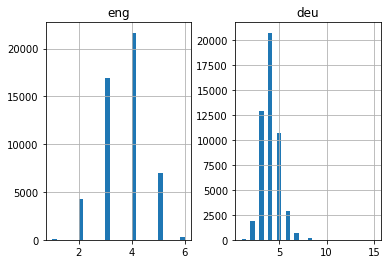

In [ ]:
length_df.hist(bins=30)
plt.show()

TOKENIZATION


In [ ]:
def tokenization(lines):
  tokenizer=Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer

In [ ]:
#preparing English Tokenizer
eng_tokenizer=tokenization(deu_eng[:,0])
eng_vocab_size=len(eng_tokenizer.word_index)+1
eng_length=8
print("English Vocabulary Size:",eng_vocab_size)

English Vocabulary Size: 6152


In [ ]:
#preparing Deutch/German Tokenizer
deu_tokenizer=tokenization(deu_eng[:,1])
deu_vocab_size=len(deu_tokenizer.word_index) +1
deu_length=8
print("German Vocabulary Size:",deu_vocab_size)


German Vocabulary Size: 10112


In [ ]:
#Encoding and pad Sequence
def encode_sequences(tokenizer,length,lines):
  seq=tokenizer.texts_to_sequences(lines)
  seq=pad_sequences(seq,maxlen=length,padding='post')
  return seq


Model Building

In [ ]:
from sklearn.model_selection import train_test_split
train,test=train_test_split(deu_eng,test_size=0.2,random_state=12)


In [ ]:
#preparing training data
trainX=encode_sequences(deu_tokenizer,deu_length,test[:,1])
trainY=encode_sequences(eng_tokenizer,eng_length,test[:,0])

#preparing test data
testX=encode_sequences(deu_tokenizer,deu_length,test[:,1])
testY=encode_sequences(eng_tokenizer,eng_length,test[:,0])


In [ ]:
# build NMT model
def build_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
      model = Sequential()
      model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
      model.add(LSTM(units))
      model.add(RepeatVector(out_timesteps))
      model.add(LSTM(units, return_sequences=True))
      model.add(Dense(out_vocab, activation='softmax'))
      return model

In [ ]:
model=build_model(deu_vocab_size,eng_vocab_size,deu_length,eng_length,512)


In [ ]:
rms= optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms,loss='sparse_categorical_crossentropy')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
filename='model.h1.translate'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=30, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

Epoch 1/30
16/16 [==============================] - 72s 4s/step - loss: 5.9449 - val_loss: 3.4508

Epoch 00001: val_loss improved from inf to 3.45079, saving model to model.h1.translate


INFO:tensorflow:Assets written to: model.h1.translate/assets


INFO:tensorflow:Assets written to: model.h1.translate/assets


Epoch 2/30
16/16 [==============================] - 64s 4s/step - loss: 3.2141 - val_loss: 3.0377

Epoch 00002: val_loss improved from 3.45079 to 3.03774, saving model to model.h1.translate


INFO:tensorflow:Assets written to: model.h1.translate/assets


INFO:tensorflow:Assets written to: model.h1.translate/assets


Epoch 3/30
16/16 [==============================] - 64s 4s/step - loss: 2.9164 - val_loss: 2.9340

Epoch 00003: val_loss improved from 3.03774 to 2.93399, saving model to model.h1.translate


INFO:tensorflow:Assets written to: model.h1.translate/assets


INFO:tensorflow:Assets written to: model.h1.translate/assets


Epoch 4/30
16/16 [==============================] - 64s 4s/step - loss: 2.7641 - val_loss: 2.8471

Epoch 00004: val_loss improved from 2.93399 to 2.84713, saving model to model.h1.translate


INFO:tensorflow:Assets written to: model.h1.translate/assets


INFO:tensorflow:Assets written to: model.h1.translate/assets


Epoch 5/30
16/16 [==============================] - 64s 4s/step - loss: 2.6859 - val_loss: 2.8011

Epoch 00005: val_loss improved from 2.84713 to 2.80113, saving model to model.h1.translate


INFO:tensorflow:Assets written to: model.h1.translate/assets


INFO:tensorflow:Assets written to: model.h1.translate/assets


Epoch 6/30
16/16 [==============================] - 64s 4s/step - loss: 2.6495 - val_loss: 2.8729

Epoch 00006: val_loss did not improve from 2.80113
Epoch 7/30
16/16 [==============================] - 64s 4s/step - loss: 2.6226 - val_loss: 2.8009

Epoch 00007: val_loss improved from 2.80113 to 2.80091, saving model to model.h1.translate


INFO:tensorflow:Assets written to: model.h1.translate/assets


INFO:tensorflow:Assets written to: model.h1.translate/assets


Epoch 8/30
16/16 [==============================] - 65s 4s/step - loss: 2.5689 - val_loss: 2.7686

Epoch 00008: val_loss improved from 2.80091 to 2.76856, saving model to model.h1.translate


INFO:tensorflow:Assets written to: model.h1.translate/assets


INFO:tensorflow:Assets written to: model.h1.translate/assets


Epoch 9/30
16/16 [==============================] - 64s 4s/step - loss: 2.4951 - val_loss: 2.7353

Epoch 00009: val_loss improved from 2.76856 to 2.73527, saving model to model.h1.translate


INFO:tensorflow:Assets written to: model.h1.translate/assets


INFO:tensorflow:Assets written to: model.h1.translate/assets


Epoch 10/30
16/16 [==============================] - 64s 4s/step - loss: 2.4390 - val_loss: 2.7319

Epoch 00010: val_loss improved from 2.73527 to 2.73195, saving model to model.h1.translate


INFO:tensorflow:Assets written to: model.h1.translate/assets


INFO:tensorflow:Assets written to: model.h1.translate/assets


Epoch 11/30
16/16 [==============================] - 64s 4s/step - loss: 2.3798 - val_loss: 2.7072

Epoch 00011: val_loss improved from 2.73195 to 2.70719, saving model to model.h1.translate


INFO:tensorflow:Assets written to: model.h1.translate/assets


INFO:tensorflow:Assets written to: model.h1.translate/assets


Epoch 12/30
16/16 [==============================] - 64s 4s/step - loss: 2.3300 - val_loss: 2.6315

Epoch 00012: val_loss improved from 2.70719 to 2.63148, saving model to model.h1.translate


INFO:tensorflow:Assets written to: model.h1.translate/assets


INFO:tensorflow:Assets written to: model.h1.translate/assets


Epoch 13/30
16/16 [==============================] - 64s 4s/step - loss: 2.2845 - val_loss: 2.6096

Epoch 00013: val_loss improved from 2.63148 to 2.60959, saving model to model.h1.translate


INFO:tensorflow:Assets written to: model.h1.translate/assets


INFO:tensorflow:Assets written to: model.h1.translate/assets


Epoch 14/30
16/16 [==============================] - 64s 4s/step - loss: 2.2284 - val_loss: 2.6173

Epoch 00014: val_loss did not improve from 2.60959
Epoch 15/30
16/16 [==============================] - 65s 4s/step - loss: 2.1825 - val_loss: 2.5740

Epoch 00015: val_loss improved from 2.60959 to 2.57399, saving model to model.h1.translate


INFO:tensorflow:Assets written to: model.h1.translate/assets


INFO:tensorflow:Assets written to: model.h1.translate/assets


Epoch 16/30
16/16 [==============================] - 64s 4s/step - loss: 2.1369 - val_loss: 2.5602

Epoch 00016: val_loss improved from 2.57399 to 2.56023, saving model to model.h1.translate


INFO:tensorflow:Assets written to: model.h1.translate/assets


INFO:tensorflow:Assets written to: model.h1.translate/assets


Epoch 17/30
16/16 [==============================] - 64s 4s/step - loss: 2.0939 - val_loss: 2.5539

Epoch 00017: val_loss improved from 2.56023 to 2.55386, saving model to model.h1.translate


INFO:tensorflow:Assets written to: model.h1.translate/assets


INFO:tensorflow:Assets written to: model.h1.translate/assets


Epoch 18/30
16/16 [==============================] - 64s 4s/step - loss: 2.0530 - val_loss: 2.5272

Epoch 00018: val_loss improved from 2.55386 to 2.52720, saving model to model.h1.translate


INFO:tensorflow:Assets written to: model.h1.translate/assets


INFO:tensorflow:Assets written to: model.h1.translate/assets


Epoch 19/30
16/16 [==============================] - 64s 4s/step - loss: 2.0202 - val_loss: 2.5042

Epoch 00019: val_loss improved from 2.52720 to 2.50418, saving model to model.h1.translate


INFO:tensorflow:Assets written to: model.h1.translate/assets


INFO:tensorflow:Assets written to: model.h1.translate/assets


Epoch 20/30
16/16 [==============================] - 64s 4s/step - loss: 1.9730 - val_loss: 2.4970

Epoch 00020: val_loss improved from 2.50418 to 2.49696, saving model to model.h1.translate


INFO:tensorflow:Assets written to: model.h1.translate/assets


INFO:tensorflow:Assets written to: model.h1.translate/assets


Epoch 21/30
16/16 [==============================] - 64s 4s/step - loss: 1.9333 - val_loss: 2.4893

Epoch 00021: val_loss improved from 2.49696 to 2.48929, saving model to model.h1.translate


INFO:tensorflow:Assets written to: model.h1.translate/assets


INFO:tensorflow:Assets written to: model.h1.translate/assets


Epoch 22/30
16/16 [==============================] - 64s 4s/step - loss: 1.8964 - val_loss: 2.5002

Epoch 00022: val_loss did not improve from 2.48929
Epoch 23/30
16/16 [==============================] - 64s 4s/step - loss: 1.8509 - val_loss: 2.4661

Epoch 00023: val_loss improved from 2.48929 to 2.46606, saving model to model.h1.translate


INFO:tensorflow:Assets written to: model.h1.translate/assets


INFO:tensorflow:Assets written to: model.h1.translate/assets


Epoch 24/30
16/16 [==============================] - 65s 4s/step - loss: 1.8207 - val_loss: 2.4305

Epoch 00024: val_loss improved from 2.46606 to 2.43045, saving model to model.h1.translate


INFO:tensorflow:Assets written to: model.h1.translate/assets


INFO:tensorflow:Assets written to: model.h1.translate/assets


Epoch 25/30
16/16 [==============================] - 64s 4s/step - loss: 1.7691 - val_loss: 2.4317

Epoch 00025: val_loss did not improve from 2.43045
Epoch 26/30
16/16 [==============================] - 64s 4s/step - loss: 1.7410 - val_loss: 2.4195

Epoch 00026: val_loss improved from 2.43045 to 2.41946, saving model to model.h1.translate


INFO:tensorflow:Assets written to: model.h1.translate/assets


INFO:tensorflow:Assets written to: model.h1.translate/assets


Epoch 27/30
16/16 [==============================] - 64s 4s/step - loss: 1.7251 - val_loss: 2.4218

Epoch 00027: val_loss did not improve from 2.41946
Epoch 28/30
16/16 [==============================] - 64s 4s/step - loss: 1.6824 - val_loss: 2.4031

Epoch 00028: val_loss improved from 2.41946 to 2.40313, saving model to model.h1.translate


INFO:tensorflow:Assets written to: model.h1.translate/assets


INFO:tensorflow:Assets written to: model.h1.translate/assets


Epoch 29/30
16/16 [==============================] - 64s 4s/step - loss: 1.6402 - val_loss: 2.3944

Epoch 00029: val_loss improved from 2.40313 to 2.39443, saving model to model.h1.translate


INFO:tensorflow:Assets written to: model.h1.translate/assets


INFO:tensorflow:Assets written to: model.h1.translate/assets


Epoch 30/30
16/16 [==============================] - 64s 4s/step - loss: 1.6148 - val_loss: 2.3854

Epoch 00030: val_loss improved from 2.39443 to 2.38539, saving model to model.h1.translate


INFO:tensorflow:Assets written to: model.h1.translate/assets


INFO:tensorflow:Assets written to: model.h1.translate/assets


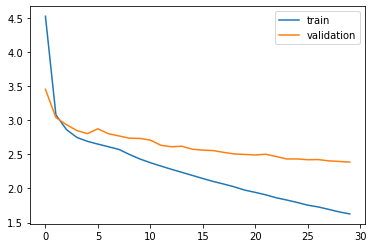

In [ ]:
#comparing training loss and validaion loss


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [ ]:
model = load_model('model.h1.translate')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
#function to convert integers to corresponding words
def get_word(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if index == n:
              return word
      return None

In [ ]:
#converting prediction to text

preds_text = []
for i in preds:
       temp = []
       for j in range(len(i)):
            t = get_word(i[j], eng_tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                     temp.append('')
                else:
                     temp.append(t)
            else:
                   if(t == None):
                          temp.append('')
                   else:
                          temp.append(t) 

       preds_text.append(' '.join(temp))

In [ ]:
# put the original English sentences in the test dataset and the predicted sentences in a dataframe


pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [ ]:
pd.set_option('display.max_colwidth', 200)

In [ ]:
pred_df.sample(15)

,actual,predicted
1552,tom did a sloppy job,tom is a
3211,do you want a bite,do you like a
3473,tell tom i called,did tom like you
3480,take tom upstairs,did tom
905,youve got to go,you know
7916,ill take the bus,ill be the
9303,theres more,its is new
6054,i want to keep that,i want to
9767,theyre ignoring us,dont be me
5977,he had a good time,he is a


In [ ]:
pred_df.head(15)

,actual,predicted
0,what is the number,he is the me
1,try it on,come it
2,we were wrong,we
3,thats untrue,it is
4,dont touch anything,you were me
5,tom is calling back,tom is me
6,i think tom is awake,i know tom to
7,what are you having,how did you
8,i like that flag,i need a
9,you have a good job,they made a


In [ ]:

pred_df.tail(15)

,actual,predicted
9985,i saw you looking,i have it you
9986,tom was so busy,tom has a
9987,where could he be,why is tom a
9988,my friend was shot,he is a
9989,come on trust me,come me
9990,life is too short,is
9991,everybody saw it,everybody wasnt that
9992,try harder,youre be
9993,he will be punished,he is a
9994,i speak swedish,i need it
